# Make Prediction Plots

Want to create 2 plots:
- A plot of the 70 cells with error bars, and real values
- Something else

## Setup

In [17]:
import torch
import torch.nn as nn

from os import listdir
from os.path import join

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

In [2]:
assert torch.cuda.is_available(), 'CUDA is not available.'

## Load some data

So I forgot to split data into global test and training sets. So will need to do that down the road. 

In [3]:
fname = join('/home/squirt/Documents/data/weather_data/', 'all_data.h5')

In [4]:
batch_size = 2 
split = 0.5
_, v_dl = utils.get_dataloaders(fname, batch_size, split)

## Load the models

Have X number of models that I train w/ cross validation. I think this could give me error bars

In [5]:
class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN, self).__init__()
        self.fc1 = nn.Linear(852,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 560)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Load X models, put on gpu for now (only have 5 models).

In [6]:
file_dir = '../saved_models'
model_files = [join(file_dir, f) for f in listdir(file_dir) if f.endswith('.pt')]

In [8]:
models = {}
for i,f in enumerate(model_files):
    model = simpleNN()
    model.load_state_dict(torch.load(f))
    model = model.float().cuda()
    model.eval()
    models[i] = model

## Make Prediction

In [10]:
batch_data = next(iter(v_dl))
l, x, y = batch_data
l = l.float().cuda()
x = x.float().cuda()
y = y.float().cuda()

# Flatten and combine
l = l.view(-1, 3*2*2)
x = x.view(-1, 70*3*2*2)
x = torch.cat((l, x), 1)

y = y.view(-1, 70*2*2*2)

In [37]:
model_preds = {}
for i, model in models.items():
    with torch.no_grad():
        y_hat = model(x)
        model_preds[i] = (y_hat, y)

## Pull Cell data from Predictions 

In [38]:
def get_cell_data(t:torch.tensor) -> torch.tensor:
    t = t.view(-1, 70, 2, 2, 2)
    # T and QV are the 2 STD channels with a 2x2 grid
    # We want to get the top left cell for both channels
    p = t[:,:,:,0,0]
    p = p.view(-1, 70, 2)
    return p

In [39]:
plot_values = {}
for k,v in model_preds.items():
    plot_values[k] = (get_cell_data(v[0]), get_cell_data(v[1]))

## Plot Column

In [52]:
def plot_column(data_dict:dict, idx:int):
    if idx not in {0,1}:
        raise ValueError('idx must be 0 or 1')
    title = 'Temp' if idx == 0 else 'QV'

    # Get the data for the 1st column (were just trying to determin if we want to park model for now)
    data = []
    for _,v in data_dict.items():
        data.append(v[0][0,:,idx])

    #print(data[0][:,0])
    data = torch.stack(data)
    #print(data[0,:,0])

    # Calculate Mean and STD
    mean = (data.mean(dim=0)).cpu().numpy()
    std = (data.std(dim=0)).cpu().numpy()

    # Get Real Values
    real = (data_dict[0][1][0,:,idx]).cpu().numpy()

    # Plot
    # Plotting
    plt.figure(figsize=(10, 6))
    x = range(len(mean))
            
    plt.plot(x, real, label='True Value', color='blue', linestyle='None', marker='o')
    plt.plot(x, mean, label='Mean Prediction', color='red', linestyle='--')
    plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2, label='Prediction Std Dev')

    plt.title(f'{title} Predictions vs True Values')
    plt.xlabel('Cell')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.show()

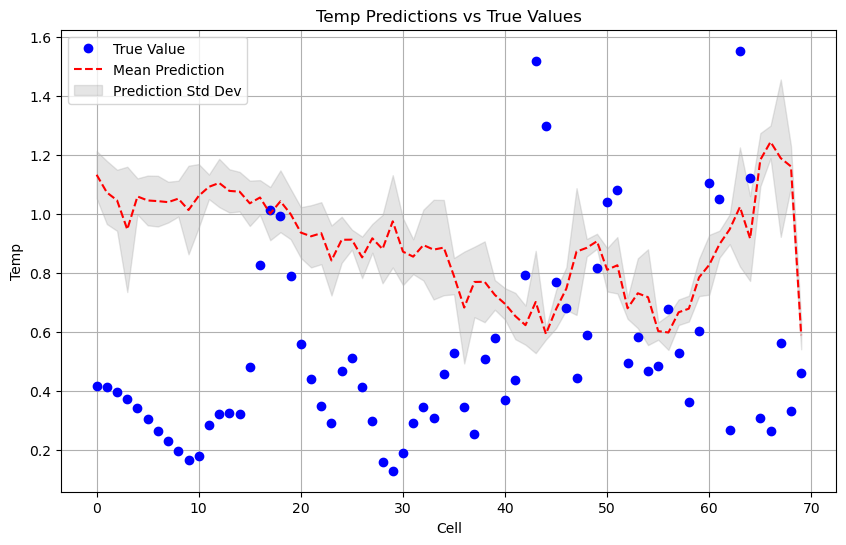

In [53]:
plot_column(plot_values, 0)